Plot figures 3, 4, 7, S1 reported in the paper.

In [35]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# uncomment to install the statannotations package
# !pip install statannotations

# Helpers 

## Read and reformat data

In [36]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df.
    Result is a .json file containing target_params as specified below.
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.

    Params:
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        data = []
        for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
            exp_res = json.load(open(fpath, "r"))

            # In case error in exp and quality is empty
            if len(exp_res["quality"]) == 0:
                continue

            row = {}
            for param in TARGET_PARAMS:
                # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                if param == "quality":
                    for jdx, qual in enumerate(exp_res["quality"]):
                        row[f"quality_{jdx}"] = qual
                else:
                    row[param] = exp_res[param]

            if keep_file_name:
                row["file_name"] = os.path.basename(fpath)

            data += [row]

        df = pd.DataFrame.from_records(data)
        df["targeting_criterion"] = df["targeting_criterion"].apply(
            lambda x: "none" if x is None else x
        )

        dfs += [df]

    if len(dfs) > 0:
        data = dfs[0]
        for df in dfs[1:]:
            data = pd.merge(
                data, df, on=list(set(TARGET_PARAMS) - set(["quality"])), how="outer"
            )
    else:
        data = pd.DataFrame()
    return data

In [37]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    values = list(filter(lambda v: v == v, values))
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
    Divides the values of the columns matching a prefix by a baseline
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [38]:
## HELPER FOR BOXPLOT


def reindex_cols(df, col_name_prefix="quality"):
    """
    Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc.
    so that they're indexed correctly, e.g, quality_1, quality_2, etc.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):
    """
    Returns long-format df.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long

## Format violin plot

In [39]:
# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax, palette=BLUEPALETTE, n=1, pointsize=200, edgecolor="white", multicolor=True
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(1.5)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

# Setting global variables 

In [40]:
# Directory containing experiment results
RES_DIR = "main_results"

# Directory to save figures
PLOT_DIR = "figures"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use("stylesheets/main_stylesheet.mplstyle")
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [
    np.round(i, 1) for i in configs.PHI_SWIPE
]  # round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [41]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Baseline quality

In [42]:
folders = ["baseline"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

Overall quality when there is no bots: 0.9


## Extreme quality

In [43]:
data = read_data(RES_DIR, ["extreme"], keep_file_name=True)
data = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index
data = get_relative(data, baseline_val, col_name_prefix="quality")
data

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4
0,32,0.05,0.1,0.5,0.0001,1.0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.325415,0.310864,0.328981,0.322504,0.327451,extreme0.json,0.360544,0.344423,0.364495,0.357319,0.362801


# Plot: Network vulnerabilities 
Fig.3: Impacts of different network structural features on the average information quality, relative to the scenario without bad actors.

In [44]:
# SHUFFLE
data = read_data(RES_DIR, ["shuffle"], keep_file_name=True)
cols = [i for i in data.columns if "file_name" in i]
data = data.dropna(subset=cols)

filename_col = cols[0]
# refer shuffling strategies from file names
data["shuffle"] = data[filename_col].apply(lambda x: x.split("_shuffle_")[0])
shuffle = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index
shuffle
data.head()

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_2,quality_3,quality_4,file_name,quality_5,quality_6,quality_7,quality_8,quality_9,shuffle
0,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.516030,...,0.527361,0.530659,0.530942,community_shuffle__None3.json,NaN,NaN,NaN,NaN,NaN,community
1,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.398837,...,0.415440,0.403607,0.416464,hub_shuffle__None3.json,0.405234,0.429722,0.417285,0.456834,0.424457,hub
2,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.504215,...,0.535919,0.527428,0.509786,all_shuffle__None3.json,0.582967,0.547735,0.528197,0.542191,0.508949,all
3,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.851542,...,0.852901,0.869652,0.858359,all_shuffle__None2.json,0.827344,0.848038,0.850199,0.846095,0.826884,all
4,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.768567,...,0.810589,0.779997,0.806253,hub_shuffle__None2.json,0.779133,0.740681,0.790036,0.798970,0.756270,hub


In [45]:
# NO SHUFFLE
data = read_data(RES_DIR, ["vary_thetaphi"])
data = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index

noshuffle = data[(data.theta == 1) & (data.phi == 0)]
noshuffle["shuffle"] = "None"

In [46]:
data = pd.concat([noshuffle, shuffle]).reset_index(drop=True)
data = get_relative(data, baseline_val, col_name_prefix="quality")
results = pivot_results(data, col_name_prefix="relative_quality")

In [47]:
results

,id,run_no,beta,quality_7,targeting_criterion,quality_3,epsilon,quality_1,quality_8,shuffle,...,graph_gml,rho,gamma,theta,file_name,quality_9,phi,quality_2,mu,relative_quality_
0,0,0,0.05,0.794347,none,0.795103,0.0001,0.716953,0.773878,None,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.01,1,NaN,0.782217,0.0,0.783240,0.5,0.850277
1,1,0,0.05,NaN,none,0.530659,0.0001,0.516689,NaN,community,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.10,1,community_shuffle__None3.json,NaN,0.0,0.527361,0.5,0.571738
2,2,0,0.05,0.417285,none,0.403607,0.0001,0.425084,0.456834,hub,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.10,1,hub_shuffle__None3.json,0.424457,0.0,0.415440,0.5,0.441893
3,3,0,0.05,0.528197,none,0.527428,0.0001,0.514320,0.542191,all,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.10,1,all_shuffle__None3.json,0.508949,0.0,0.535919,0.5,0.558646
4,4,0,0.05,0.850199,none,0.869652,0.0001,0.856069,0.846095,all,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.01,1,all_shuffle__None2.json,0.826884,0.0,0.852901,0.5,0.943469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2,9,0.05,0.417285,none,0.403607,0.0001,0.425084,0.456834,hub,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.10,1,hub_shuffle__None3.json,0.424457,0.0,0.415440,0.5,0.470279
66,3,9,0.05,0.528197,none,0.527428,0.0001,0.514320,0.542191,all,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.10,1,all_shuffle__None3.json,0.508949,0.0,0.535919,0.5,0.563892
67,4,9,0.05,0.850199,none,0.869652,0.0001,0.856069,0.846095,all,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.01,1,all_shuffle__None2.json,0.826884,0.0,0.852901,0.5,0.916149
68,5,9,0.05,0.790036,none,0.779997,0.0001,0.801412,0.798970,hub,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.01,1,hub_shuffle__None2.json,0.756270,0.0,0.810589,0.5,0.837912


Plot data for default values $\gamma=0.01$

In [48]:
plot_data = results[(results.gamma == 0.01) & (results.targeting_criterion == "none")]
plot_data.head()

,id,run_no,beta,quality_7,targeting_criterion,quality_3,epsilon,quality_1,quality_8,shuffle,...,graph_gml,rho,gamma,theta,file_name,quality_9,phi,quality_2,mu,relative_quality_
0,0,0,0.05,0.794347,none,0.795103,0.0001,0.716953,0.773878,None,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.01,1,NaN,0.782217,0.0,0.783240,0.5,0.850277
4,4,0,0.05,0.850199,none,0.869652,0.0001,0.856069,0.846095,all,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.01,1,all_shuffle__None2.json,0.826884,0.0,0.852901,0.5,0.943469
5,5,0,0.05,0.790036,none,0.779997,0.0001,0.801412,0.798970,hub,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.01,1,hub_shuffle__None2.json,0.756270,0.0,0.810589,0.5,0.851536
6,6,0,0.05,0.828089,none,0.828965,0.0001,0.837074,0.859845,community,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.01,1,community_shuffle__None2.json,0.836491,0.0,0.827764,0.5,0.938333
7,0,1,0.05,0.794347,none,0.795103,0.0001,0.716953,0.773878,None,...,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.8,0.01,1,NaN,0.782217,0.0,0.783240,0.5,0.794351


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

communities vs. hubs+communities: Welch's t-test independent samples, P_val:4.252e-06 t=7.577e+00
hubs vs. communities: Welch's t-test independent samples, P_val:1.142e-05 t=-6.714e+00
random vs. hubs: Welch's t-test independent samples, P_val:1.389e-06 t=7.871e+00
random vs. hubs+communities: Welch's t-test independent samples, P_val:6.861e-07 t=8.644e+00


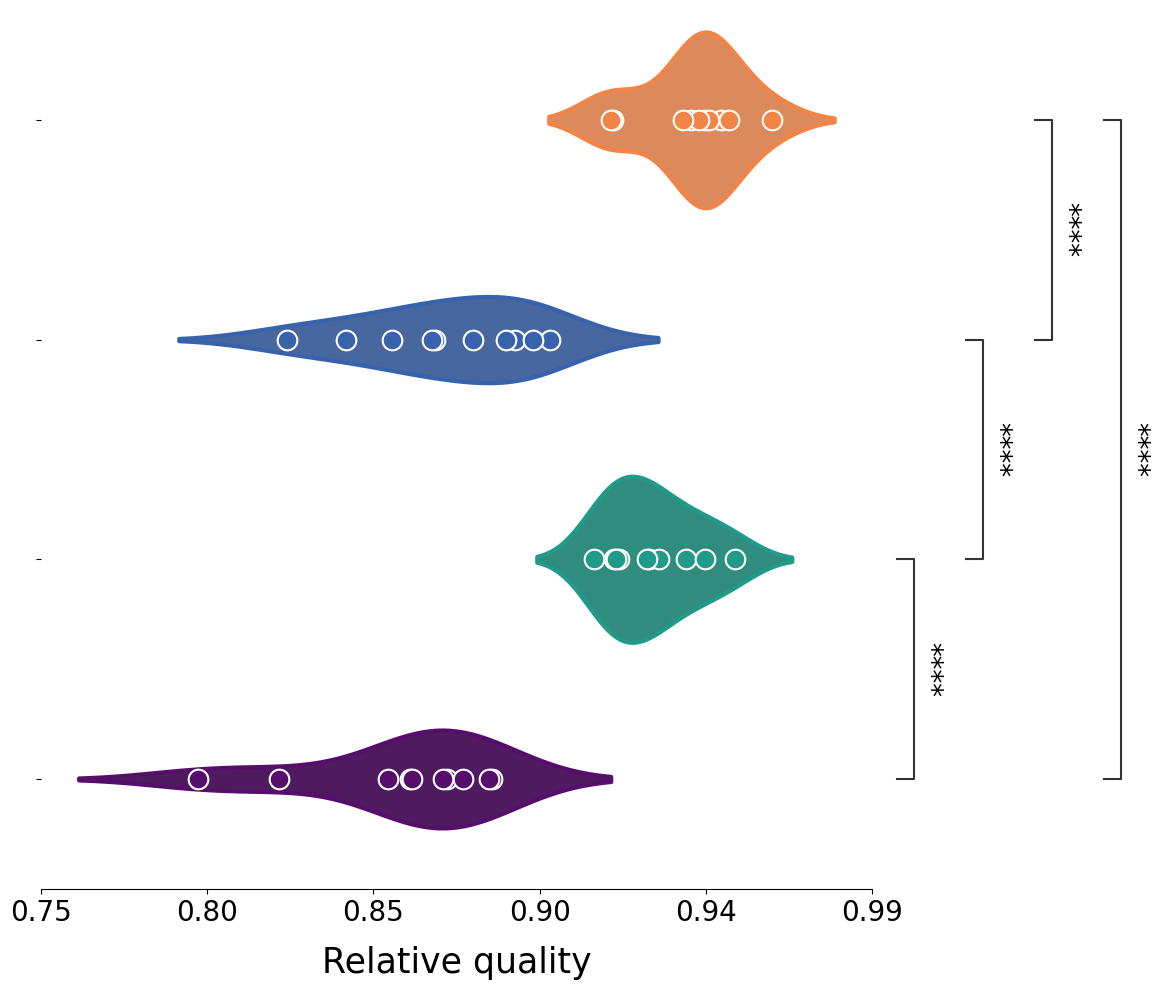

In [49]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "shuffle")
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.set_major_locator(plt.LinearLocator(6))
ax.xaxis.set_major_formatter("{x:.02f}")
order = ["random", "hubs", "communities", "hubs+communities"]

# Rename shuffles
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "random" if x == "all" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "hubs+communities" if x == "None" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(lambda x: "hubs" if x == "hub" else x)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "communities" if x == "community" else x
)

violin = sns.violinplot(
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    order=order,
    #                         scale='width',
    inner="point",
    palette=BLUEPALETTE,
)

pairs = [
    ("hubs+communities", "communities"),
    ("hubs+communities", "random"),
    ("hubs", "communities"),
    ("hubs", "random"),
]
annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    # comparisons_correction="bonferroni"
    comparisons_correction=None,
)
annotator.apply_and_annotate()

violin.set(yticklabels=[])
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)
violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=25, labelpad=14)
patch_violinplot(ax, palette=BLUEPALETTE, n=4)
point_violinplot(ax, palette=BLUEPALETTE, n=4)
sns.despine(top=True, left=True, bottom=False)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Plot: Infiltration, Deception, and Flooding Tactics
Fig.4: Effects of individual and combined tactics by bad actors on the system's message quality, relative to the scenario without bad actors. 

## Read data: Thetaphi

In [50]:
data = read_data(RES_DIR, folders=["vary_thetaphi"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")
# Remove duplicate col names and index
thetaphi = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)
thetaphi.head()

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9
0,2,0.05,0.01,0.5,0.0001,0.4,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.673311,0.639241,0.644420,0.630486,0.650957,0.650040,0.644808,0.652231,0.634583,0.635863
1,32,0.05,0.01,0.5,0.0001,1.0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.547292,0.557863,0.544803,0.546703,0.559866,0.562813,0.546122,0.542411,0.553059,0.541016
2,32,0.05,0.01,0.5,0.0001,0.9,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.545631,0.555182,0.552668,0.553663,0.546796,0.548432,0.552089,0.548256,0.551119,0.544936
3,4,0.05,0.01,0.5,0.0001,0.1,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.641028,0.615248,0.625052,0.652635,0.634102,0.619729,0.638376,0.648715,0.655751,0.632077
4,8,0.05,0.01,0.5,0.0001,0.2,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.606303,0.604308,0.618582,0.589019,0.607920,0.603543,0.592236,0.600041,0.588228,0.590145


## Read data: Phigamma

In [51]:
data = read_data(RES_DIR, folders=["vary_phigamma"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
phigamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)
phigamma.head()

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9
0,1,0.05,0.0010,0.5,0.0001,0.2,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.744866,0.763736,0.772906,0.817880,0.788915,0.764894,0.799913,0.781455,0.813764,0.755115
1,1,0.05,0.0100,0.5,0.0001,0.3,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.652522,0.670497,0.651629,0.706682,0.655434,0.653227,0.669726,0.658476,0.659622,0.657027
2,1,0.05,0.0010,0.5,0.0001,0.5,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.785949,0.812587,0.757021,0.759056,0.759900,0.754484,0.761285,0.789250,0.775156,0.789319
3,1,0.05,0.0001,0.5,0.0001,0.9,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.839617,0.836878,0.879550,0.900676,0.847509,0.875888,0.828994,0.897961,0.905162,0.900473
4,1,0.05,0.0010,0.5,0.0001,0.8,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.750752,0.747165,0.791923,0.794850,0.759150,0.764018,0.753044,0.733963,0.773130,0.738054


## Read data: Thetagamma

In [52]:
data = read_data(RES_DIR, folders=["vary_thetagamma"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
thetagamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)
thetagamma.head()

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9
0,4,0.05,0.001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.866289,0.853469,0.871346,0.865328,0.861913,0.866438,0.861601,0.864181,0.871892,0.869400
1,8,0.05,0.010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.690333,0.718891,0.683865,0.726501,0.685784,0.709861,0.684084,0.636143,0.728424,0.667117
2,32,0.05,0.001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.823555,0.858283,0.852551,0.844439,0.841659,0.847635,0.854536,0.820288,0.821507,0.864310
3,16,0.05,0.100,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.398463,0.367427,0.389114,0.388762,0.360660,0.404939,0.360405,0.381624,0.401710,0.363866
4,16,0.05,0.001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.863642,0.858668,0.846158,0.847608,0.851022,0.863459,0.844016,0.859181,0.862580,0.855047


## Plot: varying infiltration, deception and flooding
Fig.4:
(a) Varying infiltration $\gamma$, without flooding ($\theta=1$) or deception ($\phi$=0). Shading represents 95\% confidence intervals across runs in panels a--c

(b) Varying flooding $\theta$ with infiltration $\gamma=0.01$ and no deception ($\phi=0$)

(c) Varying deception $\phi$ with infiltration $\gamma=0.01$ and no flooding 

In [53]:
# VARYING GAMMA
vary_gamma = thetagamma[thetagamma.theta == 1]
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING PHI
vary_phi = phigamma[phigamma.gamma == 0.01]
vary_phi = get_relative(vary_phi, baseline_val, col_name_prefix="quality")
vary_phi = get_mean(vary_phi, col_name_prefix="relative_quality")
x = vary_phi["phi"]
y = vary_phi["mean_relative_quality"]
err = vary_phi["ci_relative_quality"]
err = vary_phi["std_relative_quality"]
phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING THETA
vary_theta = thetaphi[thetaphi.phi == 0]
vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix="relative_quality")
x = vary_theta["theta"]
y = vary_theta["mean_relative_quality"]
err = vary_theta["ci_relative_quality"]
# err = vary_theta["std_relative_quality"]
thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

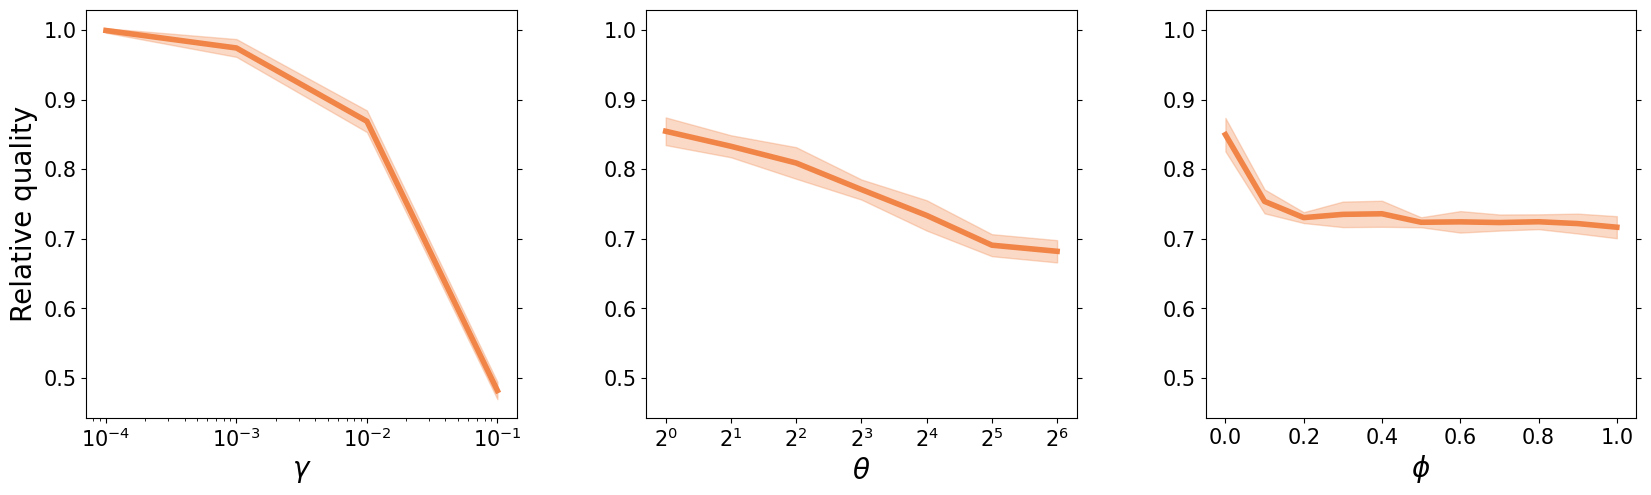

In [54]:
fpath = os.path.join(PLOT_DIR, "botparam")
color = "#F18447"  # orange

y_axis = "Relative quality"
fig, axs = plt.subplots(
    1, 3, figsize=(20, 6), sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return


# GAMMA
ax = axs[0]
draw_lines(ax, gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# # THETA
ax = axs[1]
draw_lines(ax, thetadata, color=color)
ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
ax.set_xscale("log", base=2)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.xaxis.set_major_locator(
    plt.LogLocator(base=2, numticks=len(vary_theta["theta"]) + 1)
)
# ax.xaxis.set_major_locator(plt.MultipleLocator())

# PHI
ax = axs[2]
draw_lines(ax, phidata, color=color)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)

# Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
plt.subplots_adjust(
    left=None, bottom=0.2, right=None, top=None, wspace=0.3, hspace=None
)
# plt.tight_layout()
# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.5, wspace=0.3)
if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()

## Plot: joint effects bad actor tactics
Fig.4 

(d) Joint infiltration and flooding with no deception.

(e) Joint infiltration and deception with no flooding.

(f) Joint deception and flooding with infiltration $\gamma=0.01$.


### Data: Thetaphi matrix
First we need to convert data to the right input shape for matplotlib plot_surface()

In [55]:
thetaphi = get_relative(thetaphi, baseline_val, col_name_prefix="quality")
thetaphi = get_mean(thetaphi, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetaphi = thetaphi.drop_duplicates(subset=["theta", "phi"], keep="first")
thetaphi = thetaphi.pivot(
    index="theta", columns="phi", values="mean_relative_quality"
).reset_index()
# Pandas convert phi into np.float (e.g, 0.3000000000 instead of 0.3) so we need to change column names to match with PHI
thetaphi.columns = ["theta"] + PHI
thetaphi.head()

,theta,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1,0.854513,0.736850,0.733018,0.730567,0.729567,0.719924,0.729244,0.730645,0.720078,0.722651,0.719340
1,2,0.832945,0.721548,0.716994,0.712104,0.715288,0.703082,0.698999,0.700845,0.698248,0.705782,0.699052
2,4,0.808925,0.704959,0.691489,0.691232,0.683791,0.692547,0.685041,0.683377,0.681875,0.680337,0.680433
3,8,0.770778,0.682882,0.664808,0.673503,0.665328,0.661132,0.661484,0.659243,0.659721,0.652689,0.662075
4,16,0.733606,0.662181,0.658766,0.647990,0.641197,0.639048,0.638767,0.640707,0.632515,0.636028,0.631970


In [56]:
tp_matrix = thetaphi.loc[:, PHI].values
# Check shape:
tp_matrix.shape

(7, 11)

### Data: Thetagamma matrix

In [57]:
thetagamma = get_relative(thetagamma, baseline_val, col_name_prefix="quality")
thetagamma = get_mean(thetagamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetagamma = thetagamma.drop_duplicates(subset=["theta", "gamma"], keep="first")
thetagamma = thetagamma.pivot(
    index="theta", columns="gamma", values="mean_relative_quality"
).reset_index()
thetagamma.head()

gamma,theta,0.0001,0.001,0.01,0.1
0,1,0.999305,0.974185,0.868872,0.481955
1,2,0.996800,0.973555,0.839710,0.455393
2,4,0.994847,0.958586,0.802545,0.442199
3,8,0.995003,0.959457,0.767923,0.421062
4,16,0.997038,0.947453,0.740778,0.422902


In [58]:
tg_matrix = thetagamma.loc[:, GAMMA].values
tg_matrix.shape

(7, 4)

### Data: Phigamma matrix

In [59]:
phigamma = get_relative(phigamma, baseline_val, col_name_prefix="quality")
phigamma = get_mean(phigamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
phigamma = phigamma.drop_duplicates(subset=["phi", "gamma"], keep="first")
phigamma = phigamma.pivot(
    index="phi", columns="gamma", values="mean_relative_quality"
).reset_index()
phigamma.head()

gamma,phi,0.0001,0.001,0.01,0.1
0,0.0,0.998752,0.976955,0.849666,0.491572
1,0.1,0.979774,0.892669,0.753748,0.449718
2,0.2,0.980935,0.864585,0.730430,0.439205
3,0.3,0.982747,0.857710,0.735110,0.433943
4,0.4,0.965634,0.861917,0.735965,0.427044


In [60]:
pg_matrix = phigamma.loc[:, GAMMA].values
pg_matrix.shape

(11, 4)

### Plot

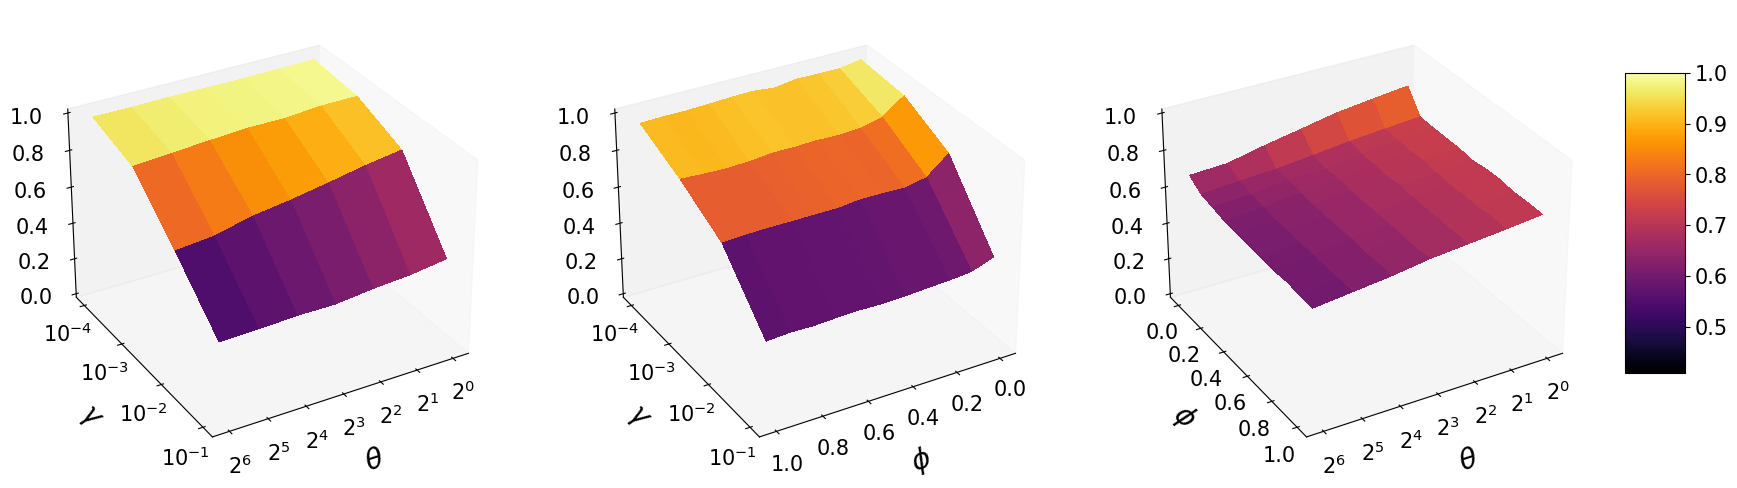

In [61]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib plot surface doesn't support plotting log scale yet
# calling ax.zaxis._set_scale('log') only labels the axis in logarithm scale but not actually plotting in logarithm scale
# Solution 1: convert to log scale (line 36) then use a custom formatter function (line 14)
# from https://stackoverflow.com/a/67774238


def log_tick_formatter(val, pos=None, base=2):
    return f"${base}^{{{val:g}}}$"


fpath = os.path.join(PLOT_DIR, "joint")
cmap = plt.get_cmap("inferno")
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(20, 6))

# Get range for plotting shared color bar
min_qual = min(min(tp_matrix.ravel()), min(tg_matrix.ravel()), min(pg_matrix.ravel()))
max_qual = max(max(tp_matrix.ravel()), max(tg_matrix.ravel()), max(pg_matrix.ravel()))
VMIN = np.round(min_qual, 2)
VMAX = np.round(max_qual, 2)

# For these exps we only plot a short range of theta
THETA_SHORT = [1, 2, 4, 8, 16, 32, 64]

## THETAGAMMA
X = THETA_SHORT
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = tg_matrix.T

# PLOT SURFACE
ax = axs[0]
surf = ax.plot_surface(
    np.log2(X),
    np.log10(Y),
    Z,
    cmap=cmap,
    linewidth=0,
    antialiased=False,
    vmin=VMIN,
    vmax=VMAX,
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks
ax.set_ylabel(f"$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)


# ## PHIGAMMA
ax = axs[1]

X = PHI
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = pg_matrix.T

# PLOT
surf = ax.plot_surface(
    X, np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_major_formatter("{x:.01f}")

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks, 'y', 'x' or 'both'
ax.set_ylabel("$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=13)

# Add a color bar which maps values to colors.
cbar_ax = fig.add_axes([0.92, 0.27, 0.03, 0.5])  # x,y,width, height
fig.colorbar(surf, shrink=0.7, aspect=10, cax=cbar_ax)


## THETAPHI
X = THETA_SHORT
Y = PHI
X, Y = np.meshgrid(X, Y)
Z = tp_matrix.T

# PLOT SURFACE
ax = axs[2]
surf = ax.plot_surface(
    np.log2(X), Y, Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_formatter("{x:.01f}")
# ax.set_zlabel(f"Relative Quality", fontsize=20, labelpad=20, rotation=90)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)
ax.set_ylabel(f"$\\phi$", fontsize=20, labelpad=13)


# rotate the axes and update
for ax in axs:
    ax.tick_params(axis="z", which="major", pad=10)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_formatter("{x:.01f}")
    ax.grid(False)
    ax.view_init(30, 60)

plt.draw()
# Saving
if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Plot: Bot targeting

Fig.7: Effects of targeting tactics. (a)~Average information quality resulting from each tactic, as well as the default random targeting, relative to the scenario without bad actors.

In [62]:
data = read_data(RES_DIR, folders=["strategies"])
data = data[data.gamma == 0.1]
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
targetdata = pivot_results(data, col_name_prefix="relative_quality")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

random vs. misinformation: Welch's t-test independent samples, P_val:3.459e-06 t=-5.994e+00
random vs. hubs: Welch's t-test independent samples, P_val:3.995e-10 t=-1.037e+01
random vs. liberal: Welch's t-test independent samples, P_val:8.678e-15 t=-2.506e+01
random vs. conservative: Welch's t-test independent samples, P_val:4.072e-18 t=-2.362e+01


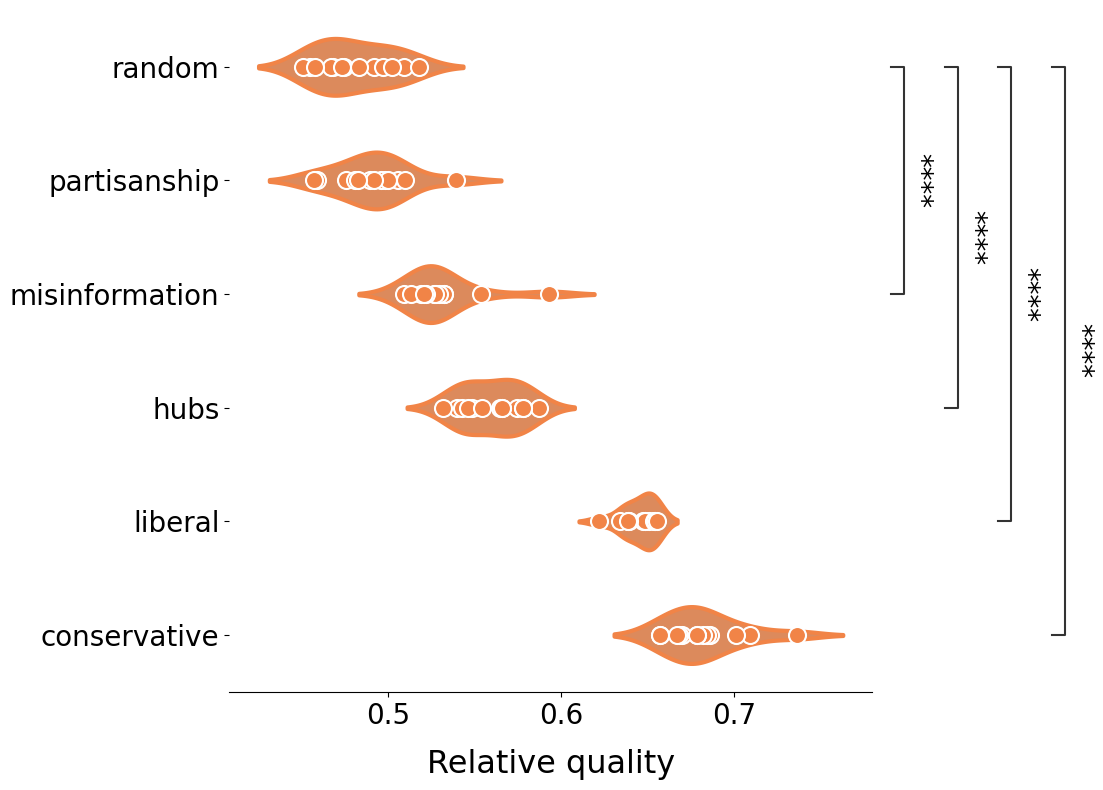

In [63]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "targeting")
color = "#F18447"  # orange

# change name of no targeting scenario
targetdata["targeting_criterion"] = targetdata["targeting_criterion"].apply(
    lambda x: "random" if x == "none" else x
)

order = ["random", "partisanship", "misinformation", "hubs", "liberal", "conservative"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
violin = sns.violinplot(
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    order=order,
    orient="h",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Add statistical significance
pairs = [
    ("misinformation", "random"),
    ("liberal", "random"),
    ("hubs", "random"),
    ("conservative", "random"),
    #         ('partisanship', 'random') #insignificant
]
annotator = Annotator(
    ax,
    pairs,
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# Format
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)

violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=23, labelpad=14)

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Supplementary

## Plot: News feed size and information load
Fig.S1: Effects of cognitive features of authentic agents on information quality.

### Sigma data

In [64]:
folders = ["vary_sigma"]
TARGET_PARAMS.append("sigma")

data = read_data(RES_DIR, folders)
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
sigmadata = pivot_results(data, col_name_prefix="quality")
sigmadata = sigmadata.sort_values(by="sigma")
sigmadata.head()

,id,run_no,relative_quality_6,relative_quality_7,graph_gml,relative_quality_3,relative_quality_5,beta,rho,gamma,...,theta,phi,relative_quality_0,relative_quality_2,relative_quality_4,relative_quality_8,sigma,mu,relative_quality_1,quality_
29,5,3,1.004973,1.003362,/N/project/simsom/simsom_v3/v3.3_10222023/data...,1.007187,1.003665,0,0.8,0,...,1,0,0.995356,1.009666,0.987396,1.003668,1,0.5,0.993445,0.909051
69,5,8,1.004973,1.003362,/N/project/simsom/simsom_v3/v3.3_10222023/data...,1.007187,1.003665,0,0.8,0,...,1,0,0.995356,1.009666,0.987396,1.003668,1,0.5,0.993445,0.905876
37,5,4,1.004973,1.003362,/N/project/simsom/simsom_v3/v3.3_10222023/data...,1.007187,1.003665,0,0.8,0,...,1,0,0.995356,1.009666,0.987396,1.003668,1,0.5,0.993445,0.891189
53,5,6,1.004973,1.003362,/N/project/simsom/simsom_v3/v3.3_10222023/data...,1.007187,1.003665,0,0.8,0,...,1,0,0.995356,1.009666,0.987396,1.003668,1,0.5,0.993445,0.907053
5,5,0,1.004973,1.003362,/N/project/simsom/simsom_v3/v3.3_10222023/data...,1.007187,1.003665,0,0.8,0,...,1,0,0.995356,1.009666,0.987396,1.003668,1,0.5,0.993445,0.898374


## Mu

In [65]:
# Read data
data = read_data(RES_DIR, ["vary_mu"])
data = reindex_cols(data, col_name_prefix="quality")

mudata = pivot_results(data, col_name_prefix="quality")

mudata = mudata.sort_values(by="mu")
mudata.head()

,id,run_no,graph_gml,beta,rho,gamma,targeting_criterion,epsilon,theta,phi,sigma,mu,quality_
33,3,6,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0,0.8,0,none,0.0001,1,0,15,0.1,0.916587
28,3,5,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0,0.8,0,none,0.0001,1,0,15,0.1,0.900978
3,3,0,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0,0.8,0,none,0.0001,1,0,15,0.1,0.897201
48,3,9,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0,0.8,0,none,0.0001,1,0,15,0.1,0.888852
23,3,4,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0,0.8,0,none,0.0001,1,0,15,0.1,0.899413


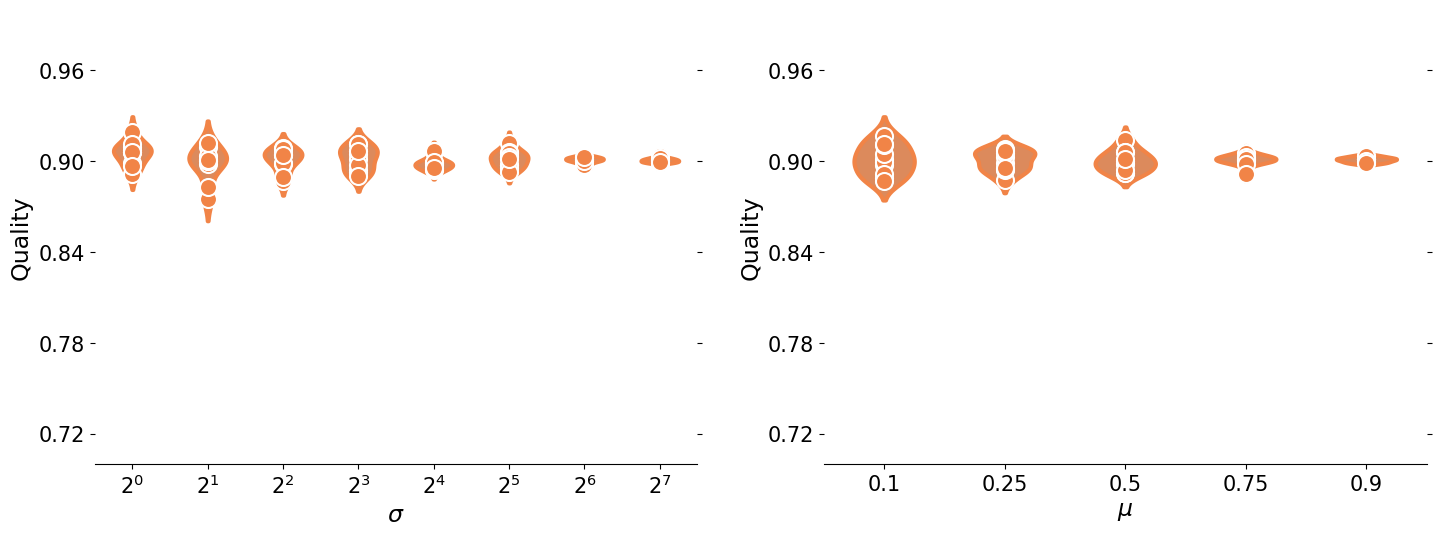

In [66]:
fpath = os.path.join(PLOT_DIR, "S1_sigmamu")
color = "#F18447"  # orange

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
plt.ylim(0.7, 1)

## news feed size sigma
ax = axs[0]
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.yaxis.set_major_locator(plt.LinearLocator(5))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=sigmadata,
    x="sigma",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)

# Formatting
ticks = range(len(sigmadata.sigma.unique()))
violin.set_xticks(ticks)
violin.set_xticklabels([f"$2^{i}$" for i in ticks])

violin.set_xlabel(f"$\\sigma$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)

## information load mu
ax = axs[1]
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.yaxis.set_major_locator(plt.MaxNLocator(7))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=mudata,
    x="mu",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Formatting
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

violin.set_xlabel(f"$\\mu$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
# leave some space between subfigs
plt.tight_layout(pad=3)

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()